### Motivation 
- The fractional abundance is extremely critical for line ratio analysis
- This might have large implications for the concentration
### Todo
- Compare fractional abundances
    - No transport
    - Check Felixes implementations
    - Check Matts implementations 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from colradpy import ionization_balance

In [10]:
#%% Specify element to analyze and path to ACD and SCD adf11 files
# TODO: add ability to model metastable-resolved populations over time
adas_path = "//share.ipp-hgw.mpg.de/documents/frhe/Documents/phd/adas"
element_name = 'neon'
element_symbol = 'Ne'
num_charge_states = 11
if element_name == "neon":
    year = '89'
    files = np.array(
        [adas_path+"/adf11/scd{}/scd{}_{}.dat".format(year,year,element_symbol.lower()),
        adas_path+"/adf11/acd{}/acd{}_{}.dat".format(year,year,element_symbol.lower()),
        ])
else:
    year = "96"
    files = np.array(
        [adas_path+"/adf11/scd{}/scd{}_{}.dat".format(year,year,element_symbol.lower()),
        adas_path+"/adf11/acd{}/acd{}_{}.dat".format(year,year,element_symbol.lower()),
        ])

In [13]:
#%% Run time-dependent ionization balance
# Times for the ionization to be done at. Note that because the matrix
# exponentiation method is used any time step or number of times can be chosen
time = np.geomspace(1e-10, 1e1, 301)
initial_abundances = np.zeros(num_charge_states)
initial_abundances[0] = 1 # 100% of the population in the neutral charge state

ion_td = ionization_balance(
    files,
    metas=np.array([0, 0, 0]),  # This argument is not used when ADF11 files are used
    temp_grid=np.array([4, 10, 50,1000]),  # Electron temperature in eV
    dens_grid=np.array([5e12, 1e13, 5e13]),  # Electron density in cm^-3
    htemp_grid=np.array([]),  # Neutral hydrogen temperature in eV
    hdens_grid=np.array([]),  # Neutral hydrogen density in cm^-3
    soln_times=time, # solution times to be calculated
    use_cx=False,
    init_abund=initial_abundances, # the initial abundance at t=0
    adf11_files=True,
)
ion_td.populate_ion_matrix()
ion_td.solve_no_source()

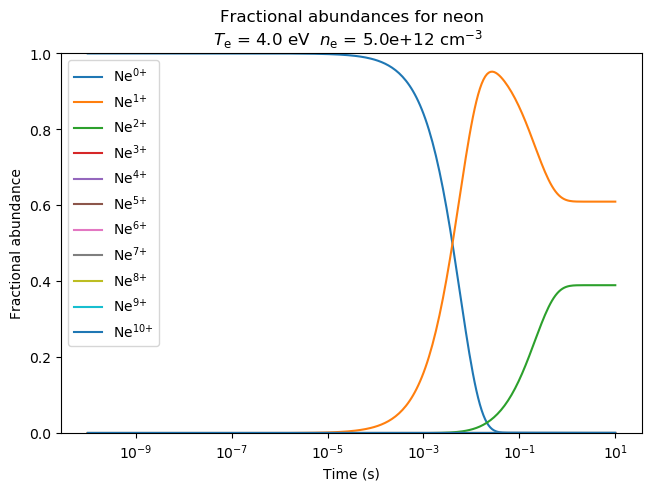

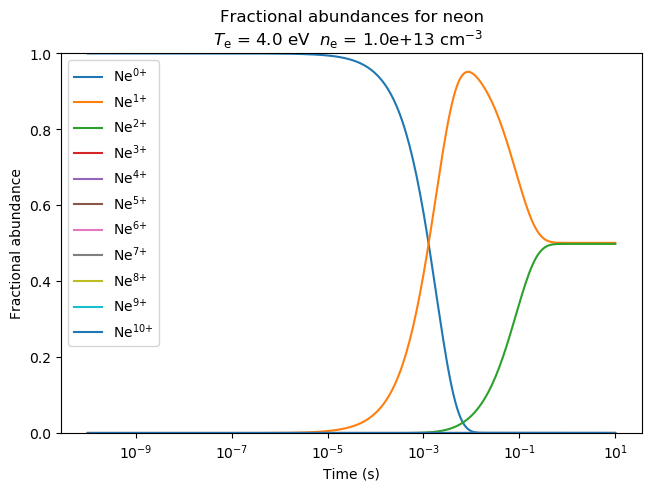

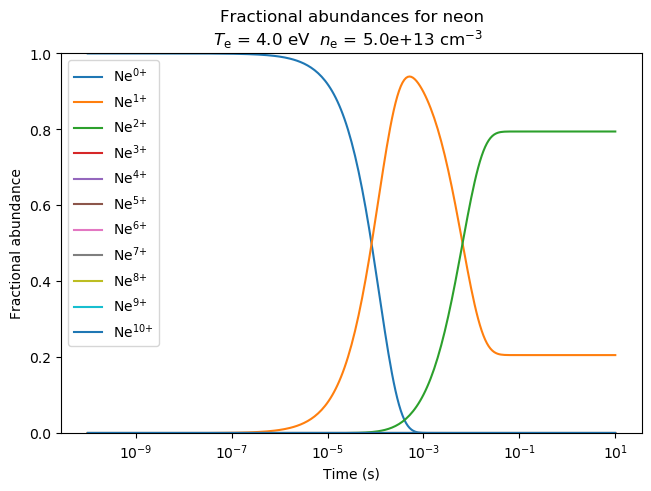

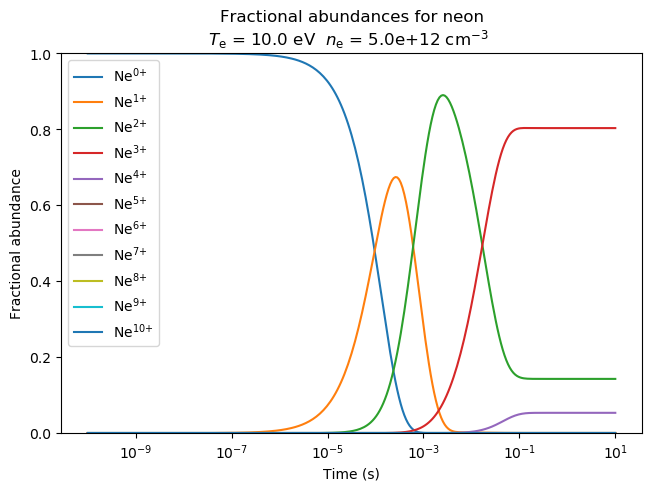

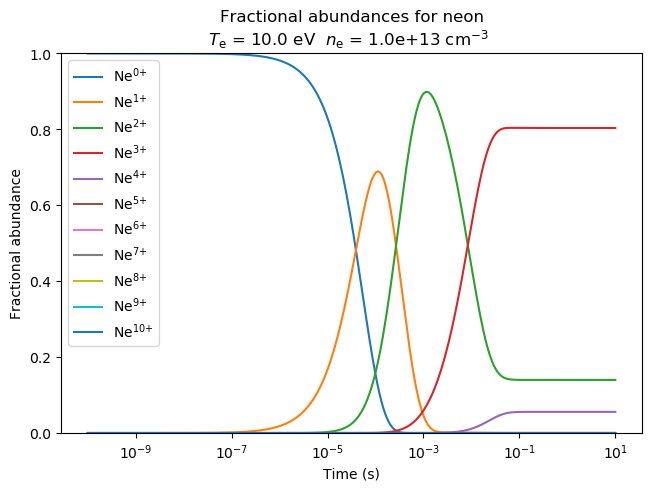

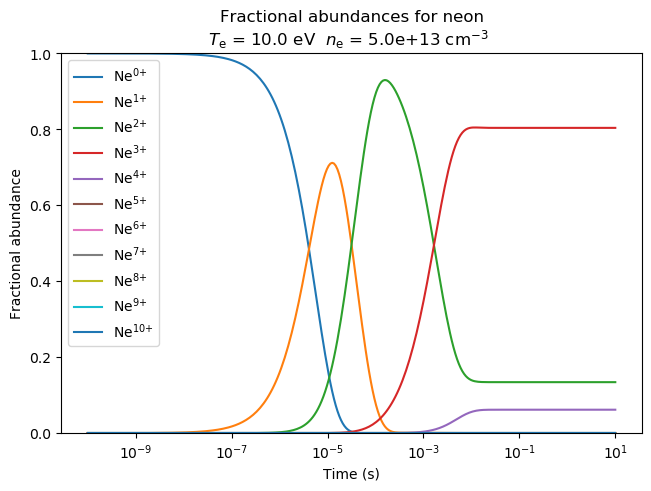

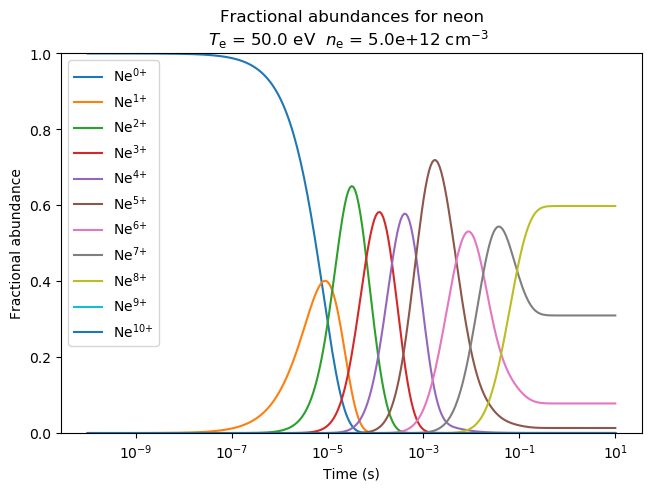

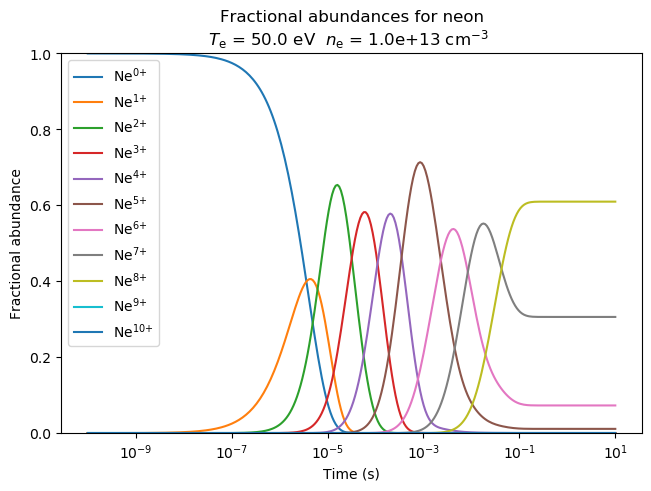

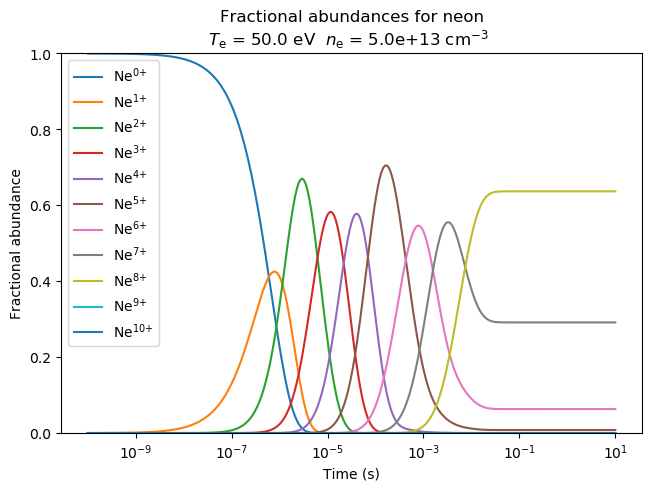

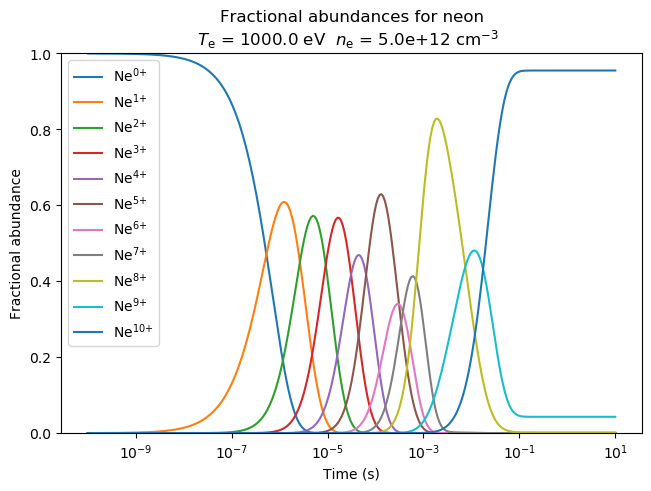

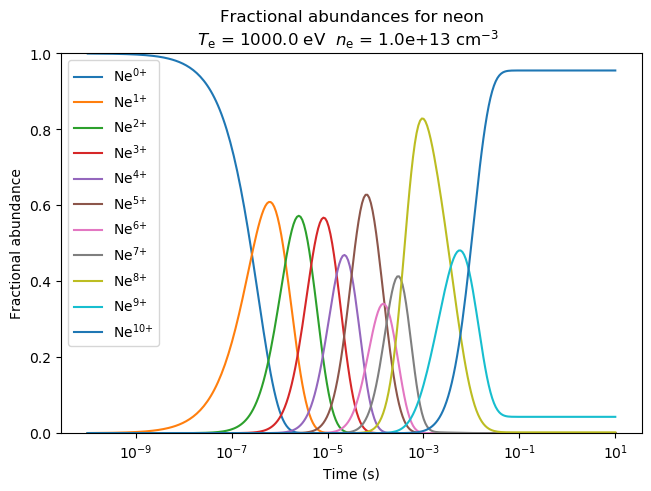

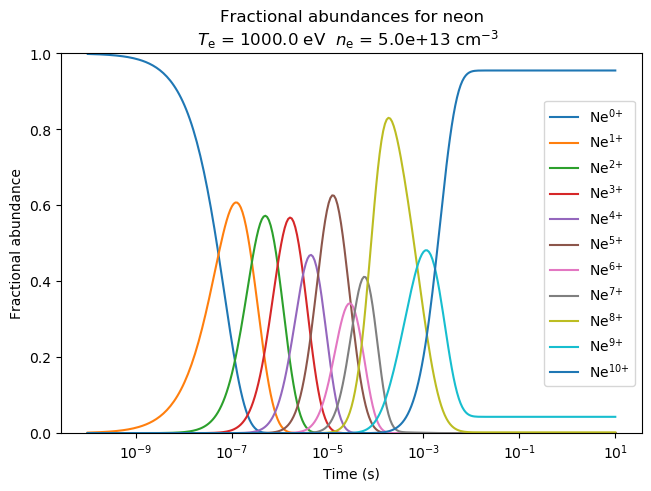

In [14]:
#%% Plot time-dependent fractional abundances
def plot_fractional_abundance(Te_index, ne_index, TH_index=None, nH_index=None):
    title = (
        f"Fractional abundances for {element_name}" + "\n"
        fr"$T_\mathrm{{e}}$ = {ion_td.data['user']['temp_grid'][Te_index]:.1f} eV  "
        fr"$n_\mathrm{{e}}$ = {ion_td.data['user']['dens_grid'][ne_index]:5.1e} $\mathrm{{cm}}^{{-3}}$  "
    )
    if np.any(ion_td.data["user"]["use_cx"]):
        title += (
            "\n"
            fr"$T_\mathrm{{H}}$ = {ion_td.data['user']['htemp_grid'][TH_index]:.1f} eV  "
            fr"$n_\mathrm{{H}}$ = {ion_td.data['user']['hdens_grid'][nH_index]:5.1e} $\mathrm{{cm}}^{{-3}}$  "
        )
    
    fig, ax = plt.subplots(constrained_layout=True)
    for charge_state in range(num_charge_states): # loop over all charge states
        ax.plot(
            time,
            ion_td.data['processed']['pops_td'][charge_state, :, Te_index, ne_index],
            label=f'$\mathrm{{{element_symbol}}}^{{{charge_state}\plus}}$',
        )
    ax.set_xscale('log')
    ax.set_ylim([0,1])
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Fractional abundance")
    ax.set_title(title)
    leg = ax.legend()
    leg.set_draggable(True)

for Te_index in range(len(ion_td.data["user"]["temp_grid"])):
    for ne_index in range(len(ion_td.data["user"]["dens_grid"])):
        plot_fractional_abundance(Te_index, ne_index)
